In [9]:
! pip install langchain_openai langgraph langgraph-swarm

In [10]:
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path=".env", override=True)
# print(os.getenv("OPENAI_API_KEY"))
# print(os.getenv("LANGCHAIN_API_KEY"))
# print(os.getenv("LANGCHAIN_PROJECT"))
# print(os.getenv("LANGCHAIN_TRACING_V2"))

False

In [17]:
from langsmith import utils
utils.tracing_is_enabled()

True

In [18]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")


In [19]:
import datetime
from collections import defaultdict
from typing import Callable

from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm

# Mock data for tools
RESERVATIONS = defaultdict(lambda: {"flight_info": {}, "hotel_info": {}})
TOMORROW = (datetime.date.today() + datetime.timedelta(days=1)).isoformat()
FLIGHTS = [
    {
        "departure_airport": "BOS",
        "arrival_airport": "JFK",
        "airline": "Jet Blue",
        "date": TOMORROW,
        "id": "1",
    }
]
HOTELS = [
    {
        "location": "New York",
        "name": "McKittrick Hotel",
        "neighborhood": "Chelsea",
        "id": "1",
    }
]


# Flight tools
def search_flights(
    departure_airport: str,
    arrival_airport: str,
    date: str,
) -> list[dict]:
    """Search flights.

    Args:
        departure_airport: 3-letter airport code for the departure airport. If unsure, use the biggest airport in the area
        arrival_airport: 3-letter airport code for the arrival airport. If unsure, use the biggest airport in the area
        date: YYYY-MM-DD date
    """
    # return all flights for simplicity
    return FLIGHTS


def book_flight(
    flight_id: str,
    config: RunnableConfig,
) -> str:
    """Book a flight."""
    user_id = config["configurable"].get("user_id")
    flight = [flight for flight in FLIGHTS if flight["id"] == flight_id][0]
    RESERVATIONS[user_id]["flight_info"] = flight
    return "Successfully booked flight"


# Hotel tools
def search_hotels(location: str) -> list[dict]:
    """Search hotels.

    Args:
        location: offical, legal city name (proper noun)
    """
    # return all hotels for simplicity
    return HOTELS


def book_hotel(
    hotel_id: str,
    config: RunnableConfig,
) -> str:
    """Book a hotel"""
    user_id = config["configurable"].get("user_id")
    hotel = [hotel for hotel in HOTELS if hotel["id"] == hotel_id][0]
    RESERVATIONS[user_id]["hotel_info"] = hotel
    return "Successfully booked hotel"


# Handoff tools
transfer_to_hotel_assistant = create_handoff_tool(
    agent_name="hotel_assistant",
    description="Transfer user to the hotel-booking assistant that can search for and book hotels.",
)
transfer_to_flight_assistant = create_handoff_tool(
    agent_name="flight_assistant",
    description="Transfer user to the flight-booking assistant that can search for and book flights.",
)


# Define agent prompt
def make_prompt(base_system_prompt: str) -> Callable[[dict, RunnableConfig], list]:
    def prompt(state: dict, config: RunnableConfig) -> list:
        user_id = config["configurable"].get("user_id")
        current_reservation = RESERVATIONS[user_id]
        system_prompt = (
            base_system_prompt
            + f"\n\nUser's active reservation: {current_reservation}"
            + f"Today is: {datetime.datetime.now()}"
        )
        return [{"role": "system", "content": system_prompt}] + state["messages"]

    return prompt


# Define agents
flight_assistant = create_react_agent(
    model,
    [search_flights, book_flight, transfer_to_hotel_assistant],
    prompt=make_prompt("You are a flight booking assistant"),
    name="flight_assistant",
)

hotel_assistant = create_react_agent(
    model,
    [search_hotels, book_hotel, transfer_to_flight_assistant],
    prompt=make_prompt("You are a hotel booking assistant"),
    name="hotel_assistant",
)

# Compile and run!
checkpointer = MemorySaver()
builder = create_swarm(
    [flight_assistant, hotel_assistant], default_active_agent="flight_assistant"
)

# Important: compile the swarm with a checkpointer to remember
# previous interactions and last active agent
app = builder.compile(checkpointer=checkpointer)


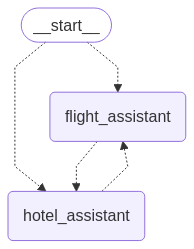

In [20]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [21]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4()), "user_id": "1"}}


In [22]:
def print_stream(stream):
    for ns, update in stream:
        print(f"Namespace '{ns}'")
        for node, node_updates in update.items():
            if node_updates is None:
                continue

            if isinstance(node_updates, (dict, tuple)):
                node_updates_list = [node_updates]
            elif isinstance(node_updates, list):
                node_updates_list = node_updates
            else:
                raise ValueError(node_updates)

            for node_updates in node_updates_list:
                print(f"Update from node '{node}'")
                if isinstance(node_updates, tuple):
                    print(node_updates)
                    continue
                messages_key = next(
                    (k for k in node_updates.keys() if "messages" in k), None
                )
                if messages_key is not None:
                    node_updates[messages_key][-1].pretty_print()
                else:
                    print(node_updates)

        print("\n\n")

    print("\n===\n")


In [23]:
print_stream(
    app.stream(
        {
            "messages": [
                {
                    "role": "user",
                    "content": "i am looking for a flight from boston to ny tomorrow",
                }
            ]
        },
        config,
        subgraphs=True,
    )
)


Namespace '('flight_assistant:c3058ced-a0a3-3ba0-3404-05568002fd41',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant
Tool Calls:
  search_flights (call_icJ6JnBgMEz1lgcdYo49QDDE)
 Call ID: call_icJ6JnBgMEz1lgcdYo49QDDE
  Args:
    departure_airport: BOS
    arrival_airport: JFK
    date: 2025-05-05



Namespace '('flight_assistant:c3058ced-a0a3-3ba0-3404-05568002fd41',)'
Update from node 'tools'
================================= Tool Message =================================
Name: search_flights

[{"departure_airport": "BOS", "arrival_airport": "JFK", "airline": "Jet Blue", "date": "2025-05-05", "id": "1"}]



Namespace '('flight_assistant:c3058ced-a0a3-3ba0-3404-05568002fd41',)'
Update from node 'agent'
================================== Ai Message ==================================
Name: flight_assistant

I found a flight for you from Boston (BOS) to New York (JFK) on May 5, 2025, with Jet Blue. Would y